# Revision

## Change Venn diagram

### Prepare data for Venn and Upset plot

In [2]:
import os
import json
import pandas as pd
from mousechd.utils.analyzer import (load_metadata,
                                     get_kingdom_df)

HOME = os.environ.get("HOME")
DATADIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs"
EVALDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/METADATA"
OUTDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS"

initial_df = load_metadata(f"{DATADIR}/processed/Imagine/metadata_20210203.csv")
prospective_df = pd.read_csv(f"{EVALDIR}/prospective.csv")
divergent_df = pd.read_csv(f"{EVALDIR}/divergent.csv")

terms = pd.read_csv(f'{DATADIR}/raw/Imagine/metadata/terminology_20201217.csv', sep=';')
terms["Kingdom"] = terms["Kingdom"].map({"Septal Defects": "Septal defects",
                                         "Atrial isomerism": "Atrial situs defects"
                                         }).fillna(terms["Kingdom"])

#### Initial cohort

In [49]:
kingdom_df = get_kingdom_df(terms, initial_df)
kingdom_df = kingdom_df[kingdom_df["Normal heart"]==0].drop("Normal heart", axis=1)
kingdom_df = kingdom_df[kingdom_df.sum(axis=1)!=0]
diseases = kingdom_df.columns.tolist()

result = {}
for i, d in enumerate(diseases):
    result[f"({i+1}) {d}"] = kingdom_df[kingdom_df[d]==1].index.tolist()

# json.dump(result, open(f"{EVALDIR}/VennData_initial_cohort.json", "w"), indent=4)
# kingdom_df.to_csv(f"{EVALDIR}/UpSet_initial_cohort.csv", index=False)
kingdom_df.sum().sort_values(ascending=False)

Kingdom
Septal defects                       37.0
Malposition of the great arteries    34.0
Atrial situs defects                 27.0
Apex malposition                     20.0
Ventricle malposition                11.0
dtype: float64

#### Prospective cohort

In [50]:
kingdom_df = prospective_df[["heart_name"] + diseases].set_index("heart_name")

result = {}
for i, d in enumerate(diseases):
    result[f"({i+1}) {d}"] = kingdom_df[kingdom_df[d]==1].index.tolist()

kingdom_df = kingdom_df[kingdom_df.sum(axis=1) > 0]

json.dump(result, open(f"{EVALDIR}/VennData_prospective_cohort.json", "w"), indent=4)
kingdom_df.to_csv(f"{EVALDIR}/UpSet_prospective_cohort.csv", index=False)
kingdom_df.sum().sort_values(ascending=False)

Malposition of the great arteries    12
Septal defects                       12
Apex malposition                      9
Atrial situs defects                  8
Ventricle malposition                 6
dtype: int64

#### Divergent cohort

In [51]:
kingdom_df = divergent_df[["heart_name"] + diseases + ["Situs inversus totalis"]].set_index("heart_name")

result = {}
for i, d in enumerate(kingdom_df.columns):
    result[f"({i+1}) {d}"] = kingdom_df[kingdom_df[d]==1].index.tolist()

kingdom_df = kingdom_df[kingdom_df.sum(axis=1) > 0]

json.dump(result, open(f"{EVALDIR}/VennData_divergent_cohort.json", "w"), indent=4)
kingdom_df.to_csv(f"{EVALDIR}/UpSet_divergent_cohort.csv", index=False)
kingdom_df.sum().sort_values(ascending=False)

Malposition of the great arteries    28
Atrial situs defects                 27
Septal defects                       25
Ventricle malposition                18
Apex malposition                     13
Situs inversus totalis                4
dtype: int64

### Circos plot

#### Initial cohort

In [5]:
kingdom_df = get_kingdom_df(terms, initial_df)
kingdom_df = kingdom_df[kingdom_df["Normal heart"]==0].drop("Normal heart", axis=1)
kingdom_df = kingdom_df[kingdom_df.sum(axis=1)!=0]
diseases = kingdom_df.columns.tolist()

def create_circos_df(df):
    diseases = list(df.columns)
    
    adj_matrix = pd.DataFrame(0, index=diseases, columns=diseases)

    for dn1 in diseases:
        for dn2 in diseases:
            if dn1 != dn2:
                adj_matrix.loc[dn1, dn2] = (df[dn1].astype(bool) & df[dn2].astype(bool)).sum()
    
    result = []
    for i, col_from in enumerate(diseases):
        for col_to in diseases[(i+1):]:
            value = (df[col_from].astype(bool) & df[col_to].astype(bool)).sum()
            result.append([col_from, col_to, 
                           value*df[col_from].sum()/adj_matrix[col_from].sum(), 
                           value*df[col_to].sum()/adj_matrix[col_to].sum()])
                
    return pd.DataFrame(result, columns=["from", "to", "value1", "value2"])

df = create_circos_df(kingdom_df)
df.to_csv(f"{EVALDIR}/circos_initial_cohort.csv", index=False)
    

#### Prospective cohort

In [6]:
kingdom_df = prospective_df[["heart_name"] + diseases].set_index("heart_name")
df = create_circos_df(kingdom_df)
df.to_csv(f"{EVALDIR}/circos_prospective_cohort.csv", index=False)

#### Divergent cohort

In [7]:
kingdom_df = divergent_df[["heart_name"] + diseases + ["Situs inversus totalis"]].set_index("heart_name")
df = create_circos_df(kingdom_df)
df.to_csv(f"{EVALDIR}/circos_divergent_cohort.csv", index=False)

## Fine-tuning on divergent cohort still falls short

In [402]:
import numpy as np

ini_res = []

for i in range(1, 6):
    df = pd.read_csv(f"{OUTDIR}/Classifier/F{i}/results/summary.csv")
    res = df[(df["ckpt"]=="best_model.hdf5") & (df["testfile"]=="test.csv")]
    test = pd.read_csv(f"{DATADIR}/labels/base/5folds/F{i}/test.csv")
    ini_res.append([f"F{i}"] + list(res[["acc", "bal_acc", "sens", "spec", "auc"]].values[0]) + [139 - len(test), len(test)])
    
ini_res = pd.DataFrame(ini_res, columns=["fold", "acc", "bal_acc", "sens", "spec", "auc", "ini_train", "ini_test"])
ini_res_avg = pd.DataFrame({"exp": ["I1"],
                            "acc": [ini_res["acc"].mean()],
                            "bal_acc": [ini_res["bal_acc"].mean()],
                            "sens": [ini_res["sens"].mean()],
                            "spec": [ini_res["spec"].mean()],
                            "auc": [ini_res["auc"].mean()],
                            "ini_train": [np.round(ini_res["ini_train"].mean())],
                            "ini_test": [np.round(ini_res["ini_test"].mean())]})

res_df = []

exps = ["I2", "I3", "retrain_refined", "div_scratch"]

for exp in exps:
    df = pd.read_csv(f"{OUTDIR}/Classifier/{exp}/results/summary.csv")
    res = df[df["ckpt"]=="best_model.hdf5"]
    
    if exp=="retrain_refined":
        exp = "D1"
    if exp == "div_scratch":
        exp = "D2"
 
    res_df.append([exp] + list(res[["acc", "bal_acc", "sens", "spec", "auc"]].values[0]))
    
res_df = pd.DataFrame(res_df, columns=["exp", "acc", "bal_acc", "sens", "spec", "auc"])
res_df["ini_train"] = [58, 40, 0, 0]
res_df["pros_train"] = [0, 0, 18, 18]
res_df["div_train"] = [0, 18, 40, 40]
res_df["ini_test"] = [81, 99, 0, 0]
res_df["div_test"] = [0, 0, 40, 40]
res_df = pd.concat([ini_res_avg, res_df], ignore_index=True).fillna(0)
res_df

,exp,acc,bal_acc,sens,spec,auc,ini_train,ini_test,pros_train,div_train,div_test
0,I1,0.950000,0.942738,0.925000,0.960476,0.958750,111.0,28.0,0.0,0.0,0.0
1,I2,0.777778,0.761941,0.727273,0.796610,0.771957,58.0,81.0,0.0,0.0,0.0
2,I3,0.696970,0.722222,0.777778,0.666667,0.799383,40.0,99.0,0.0,18.0,0.0
3,D1,0.850000,0.835165,0.785714,0.884615,0.914835,0.0,0.0,18.0,40.0,40.0
4,D2,0.725000,0.739011,0.785714,0.692308,0.785714,0.0,0.0,18.0,40.0,40.0


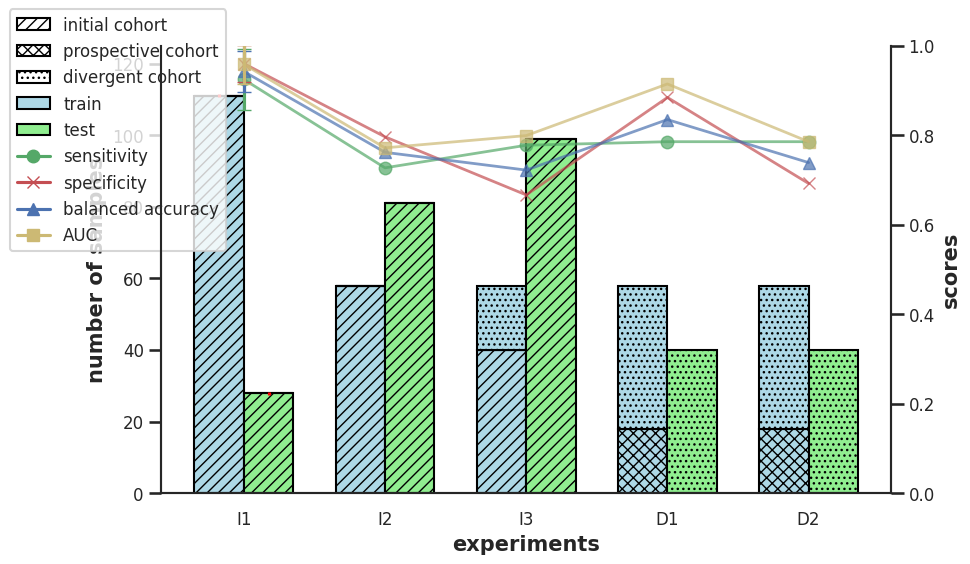

In [446]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["axes.linewidth"] = 1.5
label_size = 15


df = res_df.copy()

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for training samples (left y-axis)
train_stacked = df[['ini_train', 'pros_train', 'div_train']].values.T
test_stacked = df[['ini_test', 'div_test']].values.T

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(df['exp']))

# Consistent colors for train and test
train_color = 'lightblue'
test_color = 'lightgreen'

# Define hatches for initial, prospective, and divergent
hatch_ini = '///'
hatch_pros = 'xxx'
hatch_div = '...'


# Plot bars for training samples
bar_train_ini = ax1.bar(index, train_stacked[0], bar_width, label='Initial Train', color=train_color, hatch=hatch_ini, edgecolor="black")
bar_train_pros = ax1.bar(index, train_stacked[1], bar_width, bottom=train_stacked[0], label='Prospective Train', color=train_color, hatch=hatch_pros, edgecolor="black")
bar_train_div = ax1.bar(index, train_stacked[2], bar_width, bottom=train_stacked[0] + train_stacked[1], label='Divergent Train', color=train_color, hatch=hatch_div, edgecolor="black")

# Plot bars for testing samples
bar_test_ini = ax1.bar(index + bar_width, test_stacked[0], bar_width, label='Initial Test', color=test_color, hatch=hatch_ini, edgecolor="black")
bar_test_div = ax1.bar(index + bar_width, test_stacked[1], bar_width, bottom=test_stacked[0], label='Divergent Test', color=test_color, hatch=hatch_div, edgecolor="black")

ax1.errorbar(index[0], ini_res["ini_train"].mean(), yerr=ini_res["ini_train"].std(), color="red")
ax1.errorbar(index[0] + bar_width, ini_res["ini_test"].mean(), yerr=ini_res["ini_test"].std(), color="red")

# Set labels for the left y-axis
ax1.set_xlabel('experiments', fontsize=label_size, fontweight="bold")
ax1.set_ylabel('number of samples', fontsize=label_size, fontweight="bold")
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(df['exp'])
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0, 125)

# Plot accuracy, balanced accuracy, sensitivity, and specificity on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylim(0,1)
ax2.spines["top"].set_visible(False)
markers = ("o", "x", "^", 's')
colors = ('g', 'r', 'b', 'y')
abv_metrics = ["sens", "spec", "bal_acc", "auc"]
metrics = ["sensitivity", "specificity", "balanced accuracy", "AUC"]
for i in range(len(metrics)):
    ax2.plot(index + bar_width/2, df[abv_metrics[i]], 
             color=colors[i], 
             marker=markers[i], 
             label=metrics[i],
             linewidth=2, 
             alpha=0.7)
    ax2.errorbar(index[0] + bar_width/2, ini_res[abv_metrics[i]].mean(), yerr=ini_res[abv_metrics[i]].std(), color=colors[i], capsize=5)

# Set labels for the right y-axis
ax2.set_ylabel('scores', fontsize=label_size, fontweight="bold")

# Create grouped legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Cohort legend with no colors, only patterns
legend_cohort = [
    Patch(facecolor='none', edgecolor='black', hatch=hatch_ini, label='initial cohort'),
    Patch(facecolor='none', edgecolor='black', hatch=hatch_pros, label='prospective cohort'),
    Patch(facecolor='none', edgecolor='black', hatch=hatch_div, label='divergent cohort')
]

# Data set legend (train and test)
legend_dataset = [
    Patch(facecolor=train_color, label='train', edgecolor='black'),
    Patch(facecolor=test_color, label='test', edgecolor='black')
]

# Metrics legend (lines for metrics)
legend_metrics = [
    Line2D([0], [0], color=colors[i], marker=markers[i], label=metrics[i]) for i in range(len(metrics))
]

# Combine all legends into one
combined_legend = legend_cohort + legend_dataset + legend_metrics
combined_labels = [entry.get_label() for entry in combined_legend]

ax1.legend(combined_legend, combined_labels, loc='upper right', bbox_to_anchor=(0.1, 1.1), fontsize=12)

# Adjust layout
plt.tight_layout()
outdir = f"{EVALDIR}/../FIGURES/revision1" 
os.makedirs(outdir, exist_ok=True)
plt.savefig(f"{outdir}/fine-tuning.svg", bbox_inches="tight", dpi=500)

## Model uncertainty

### Probabilities

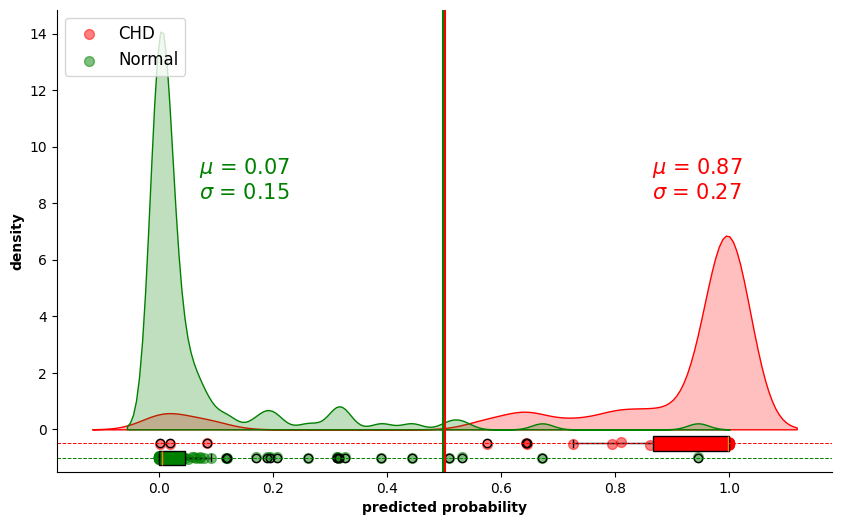

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

dfs = []
for i in range(1, 6):
    df = pd.read_csv(f"{OUTDIR}/Classifier/F{i}/results/best_model.hdf5/test.csv")
    df["fold"] = f"F{i}"
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)

# Example data
pos = df[df["label"] == 1]["prob"].values  # Positive class probabilities
neg = df[df["label"] == 0]["prob"].values  # Negative class probabilities

# Calculate mean and std for both classes
pos_mean, pos_std = np.mean(pos), np.std(pos)
neg_mean, neg_std = np.mean(neg), np.std(neg)

# Create scatter plot for both positive and negative classes
plt.figure(figsize=(10, 6))

# Positive class scatter plot above
plt.scatter(pos, np.random.normal(-0.5, 0.02, len(pos)), color="r", marker="o", alpha=0.5, label='CHD', s=50)

# Negative class scatter plot below
plt.scatter(neg, np.random.normal(-1, 0.02, len(neg)), color="g", marker="o", alpha=0.5, label='Normal', s=50)

plt.boxplot(pos, vert=False, positions=[-0.5], widths=0.5, patch_artist=True, boxprops=dict(facecolor='r', color='k'))
plt.boxplot(neg, vert=False, positions=[-1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='g', color='k'))

# Add KDE (Kernel Density Estimation) to show distribution
sns.kdeplot(pos, bw_adjust=0.3, fill=True, color="r", clip_on=False)
sns.kdeplot(neg, bw_adjust=0.3, fill=True, color="g", clip_on=False)

# Customizing the plot
plt.axhline(-0.5, color='r', linestyle='--', linewidth=0.7)
plt.axhline(-1, color='g', linestyle='--', linewidth=0.7)

# Add mean and std annotations for CHD
plt.text(pos_mean, 8, f"$\mu$ = {pos_mean:.2f}\n$\sigma$ = {pos_std:.2f}", color="r", ha="left", va="bottom", fontsize=15)

# Add mean and std annotations for Normal
plt.text(neg_mean, 8, f"$\mu$ = {neg_mean:.2f}\n$\sigma$ = {neg_std:.2f}", color="g", ha="left", va="bottom", fontsize=15)

e = 0.0025
plt.axvline(0.5+e, color='r', linestyle='-')
plt.axvline(0.5-e, color='g', linestyle='-')

# Titles and labels
plt.xlabel("predicted probability", fontweight="bold")
plt.ylabel("density", fontweight="bold")

# Add a legend
plt.legend(loc="upper left", fontsize=12)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

yticks = np.arange(0, 16, step=2)
plt.yticks(yticks, yticks)
plt.tick_params(bottom=True, left=True)

outdir = f"{EVALDIR}/../FIGURES/revision1" 
os.makedirs(outdir, exist_ok=True)
# plt.savefig(f"{outdir}/probability_distribution.svg", bbox_inches="tight", dpi=500)

In [99]:
normal = df[df["label"]==0]
chd = df[df["label"]==1]
normal["loss"] = normal["prob"]
chd["loss"] = 1 - chd["prob"]
df = pd.concat([normal, chd], ignore_index=True)
normal["loss"].mean(), chd["loss"].mean(), df["loss"].mean()

/tmp/ipykernel_905497/4025356592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal["loss"] = normal["prob"]
/tmp/ipykernel_905497/4025356592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chd["loss"] = 1 - chd["prob"]


(0.07109291981181287, 0.13471164465789476, 0.08848508919419495)

### Bootstrap

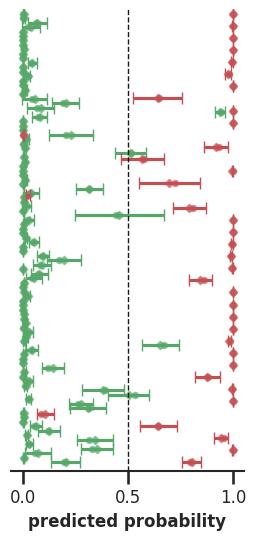

In [484]:
bootstrap_dfs = []

for i in range(1, 6):
    for bi in range(1,51):
        bt_df = pd.read_csv(f"{OUTDIR}/Classifier/F{i}/results/best_model.hdf5/bootstrap/bootstrap_{bi:02d}.csv")
        bt_df["fold"] = f"F{i}"
        bt_df["bootstrap"] = bi
        bootstrap_dfs.append(bt_df)

bt_df = pd.concat(bootstrap_dfs, ignore_index=True)

df["prob_avg"] = df["heart_name"].map(bt_df.groupby("heart_name")["prob"].agg("mean").to_dict())
df["prob_std"] = df["heart_name"].map(bt_df.groupby("heart_name")["prob"].agg("std").to_dict())

# Example data
pos = df[df["label"] == 1]["prob"].values  # Positive class probabilities
neg = df[df["label"] == 0]["prob"].values  # Negative class probabilities

pos = df[df["label"] == 1]["prob_avg"].values  # Positive class probabilities
neg = df[df["label"] == 0]["prob_avg"].values  # Negative class probabilities
pos_err = df[df["label"] == 1]["prob_std"].values
neg_err = df[df["label"] == 0]["prob_std"].values
pos_pos = np.linspace(0, 10, len(pos))
neg_pos = np.linspace(0, 10, len(neg))

# Create scatter plot for both positive and negative classes
plt.figure(figsize=(3, 6))

plt.scatter(neg, neg_pos, color="g", marker="D", alpha=0.6, s=15)
for i in range(len(neg)):
    plt.errorbar(neg[i], neg_pos[i], xerr=neg_err[i], color="g", capsize=4)

plt.scatter(pos, pos_pos, color="r", marker="D", alpha=0.6, s=15)
for i in range(len(pos)):
    plt.errorbar(pos[i], pos_pos[i], xerr=pos_err[i], color="r", capsize=4)
    
    
pos = df[df["label"] == 1]["prob"].values  # Positive class probabilities
neg = df[df["label"] == 0]["prob"].values  # Negative class probabilities


# Negative class scatter plot below
plt.scatter(neg, neg_pos, color="g", marker="o", alpha=0.6, label='Normal', s=15)
# Positive class scatter plot above
plt.scatter(pos, pos_pos, color="r", marker="o", alpha=0.6, label='CHD', s=15)

plt.ylim(-0.2, 10.1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.axvline(0.5, color='k', linestyle='--', linewidth=1)

plt.xlabel("predicted probability", fontweight="bold", fontsize=12)

plt.yticks([])
plt.tick_params(bottom=True);
outdir = f"{EVALDIR}/../FIGURES/revision1" 
os.makedirs(outdir, exist_ok=True)
plt.savefig(f"{outdir}/bootstrap_probabilities.svg", bbox_inches="tight", dpi=500)

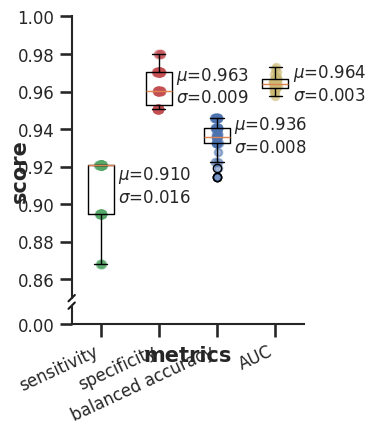

In [ ]:
from mousechd.classifier.utils import calculate_metrics
from brokenaxes import brokenaxes

metrics_df = []

# scores = calculate_metrics(df["prob"].values, df["label"].values)
# metrics_df.append(["initial", scores["sens"], scores["spec"], scores["bal_acc"], scores["auc"]])

for i in range(1, 51):
    tmp_df = bt_df[bt_df["bootstrap"]==i]
    scores = calculate_metrics(tmp_df["prob"].values, tmp_df["label"].values)
    metrics_df.append([f"bootstrap{i:2d}", scores["sens"], scores["spec"], scores["bal_acc"], scores["auc"]])

metrics_df = pd.DataFrame(metrics_df, columns=["exp", "sens", "spec", "bal_acc", "auc"])

markers = ("o", "x", "^", 's')
colors = ('g', 'r', 'b', 'y')
abv_metrics = ["sens", "spec", "bal_acc", "auc"]
metrics = ["sensitivity", "specificity", "balanced accuracy", "AUC"]

vals, names = [], []
for i, m in enumerate(abv_metrics):
    vals.append(metrics_df[m].values)
    names.append(metrics[i])

plt.figure(figsize=(3, 4))
ax = brokenaxes(ylims=((0, 0.01), (0.85, 1)), hspace=0.05)
ax.boxplot(vals, labels=names);
for i in range(len(metrics)):
    ax.scatter(np.random.normal(i+1, 0.02, len(metrics_df)), metrics_df[abv_metrics[i]].values, color=colors[i], s=30, alpha=0.5)
    ax.text(i+1.3, metrics_df[abv_metrics[i]].mean(), 
            f"$\mu$={metrics_df[abv_metrics[i]].mean():.3f}\n$\sigma$={metrics_df[abv_metrics[i]].std():.3f}",
            fontsize=12,
            ha="left",
            va="center")

ax.set_xticks([i+1 for i in range(len(metrics))], metrics, rotation=25, ha="right")
ax.set_xlabel("metrics", fontweight="bold", fontsize=15)
ax.set_ylabel("score", fontweight="bold", fontsize=15)

outdir = f"{EVALDIR}/../FIGURES/revision1" 
os.makedirs(outdir, exist_ok=True)
# plt.savefig(f"{outdir}/bootstrap_metrics.svg", bbox_inches="tight", dpi=500)

### GradCAMs of uncertain cases

In [84]:
df = pd.read_csv(f"{OUTDIR}/GradCAMs_uncertainty1/probabilities.csv")

meta_df = pd.read_csv(f"{DATADIR}/publicOwey/metadata_full.csv")
meta_df["label"] = 1 - meta_df["Normal heart"]

res = {}

heartnames = df["heart_name"].unique()

for hn in heartnames:
    df_tmp = df[df["heart_name"]==hn]
    res[hn] = {}
    res[hn]["label"] = meta_df.set_index("Heart name").to_dict()["label"][hn]
    res[hn]["max_prob"] = df_tmp[df_tmp["prob"]==df_tmp["prob"].max()]["prob"].values[0]
    res[hn]["max_bt"] = df_tmp[df_tmp["prob"]==df_tmp["prob"].max()]["bootstrap"].values[0]
    res[hn]["min_prob"] = df_tmp[df_tmp["prob"]==df_tmp["prob"].min()]["prob"].values[0]
    res[hn]["min_bt"] = df_tmp[df_tmp["prob"]==df_tmp["prob"].min()]["bootstrap"].values[0]

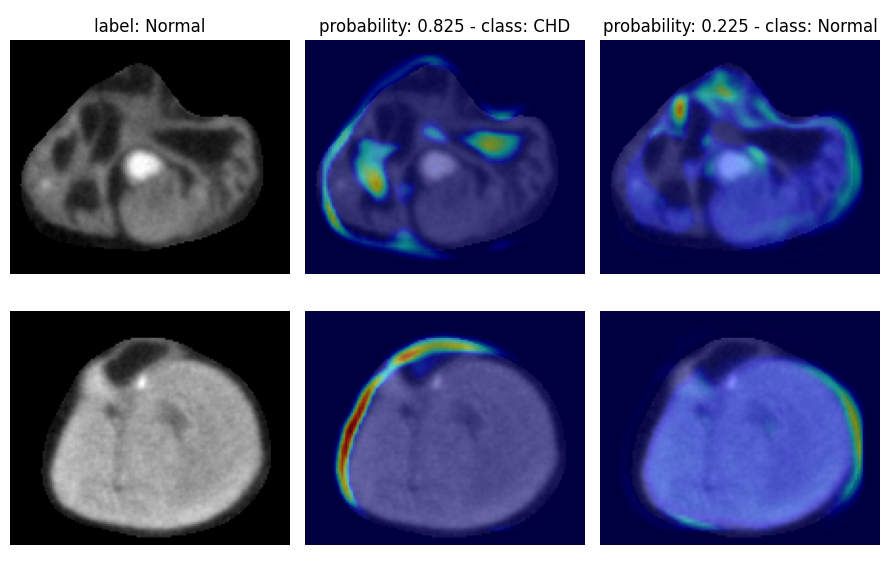

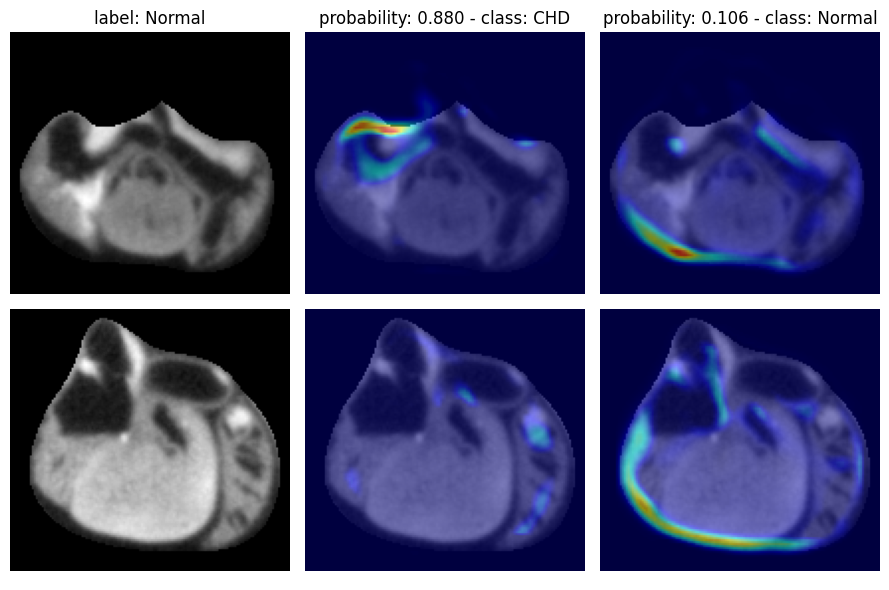

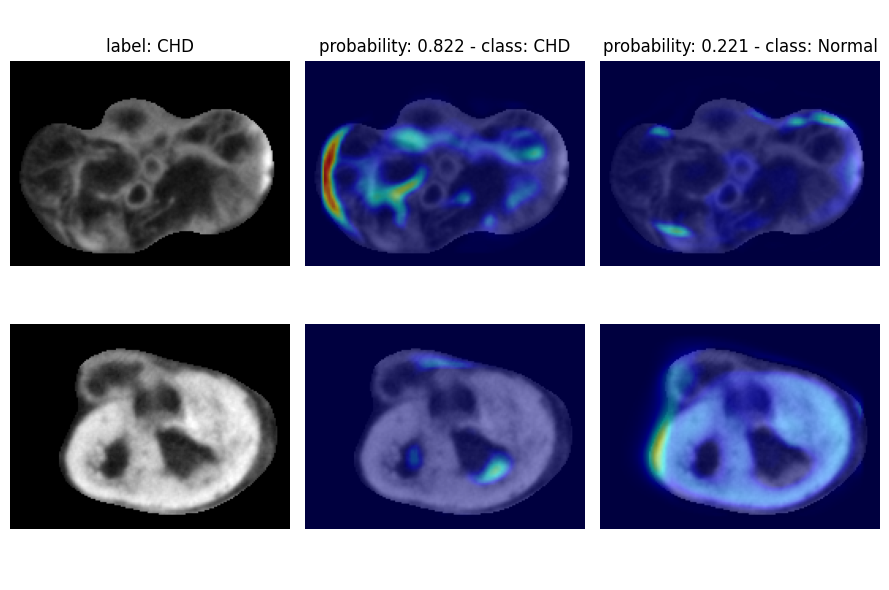

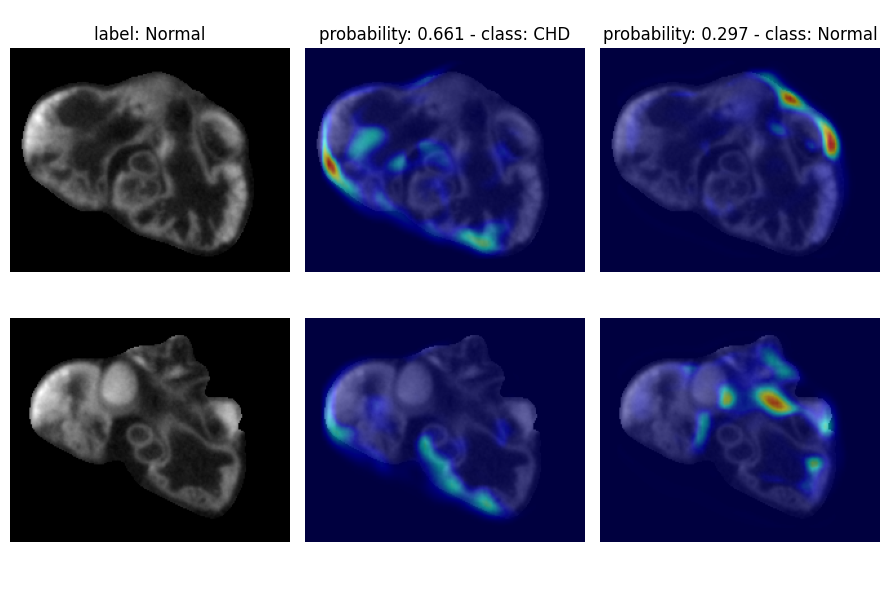

In [ ]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from mousechd.utils.analyzer import plot_gallery

heartnames = res.keys()
for hn in heartnames:
    im = tifffile.imread(os.path.join(OUTDIR, "GradCAMs_uncertainty1",
                                    res[hn]["max_bt"], hn, "image.tif"))
    max_cam = tifffile.imread(os.path.join(OUTDIR, "GradCAMs_uncertainty1",
                                    res[hn]["max_bt"], hn, "cam_1.tif"))
    min_cam = tifffile.imread(os.path.join(OUTDIR, "GradCAMs_uncertainty1",
                                    res[hn]["min_bt"], hn, "cam_0.tif"))

    i = max_cam.sum(axis=(1,2,3)).argmax()

    plt.subplots(figsize=(9, 6))
    plt.axis("off")
    plt.subplot(2, 3, 1)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.title("label: {}".format({0: "Normal", 1: "CHD"}[res[hn]["label"]]))
    plt.axis("off")
    plt.subplot(2, 3, 2)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.imshow(max_cam[i], alpha=0.5)
    plt.axis("off")
    plt.title("probability: {:.03f} - class: CHD".format(res[hn]["max_prob"]))
    plt.subplot(2, 3, 3)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.imshow(min_cam[i], alpha=0.5)
    plt.title("probability: {:.03f} - class: Normal".format(res[hn]["min_prob"]))
    plt.axis("off")

    i = min_cam.sum(axis=(1,2,3)).argmax()

    plt.axis("off")
    plt.subplot(2, 3, 4)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.axis("off")
    plt.subplot(2, 3, 5)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.imshow(max_cam[i], alpha=0.5)
    plt.axis("off")
    plt.subplot(2, 3, 6)
    plt.imshow(im[i, :, :], cmap="gray")
    plt.imshow(min_cam[i], alpha=0.5)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{EVALDIR}/../FIGURES/revision1/GradCAM_uncertainty_{hn}.svg", 
                bbox_inches="tight", dpi=1000)

### Rotation invariance?

## Compare with SOTA in 3D segmentation and classification

### Segmentation

In [52]:
nnunet_df = pd.read_csv(f"{OUTDIR}/HeartSeg/metrics_postprocessed_ensemble.csv")
swin_df = pd.read_csv(f"{OUTDIR}/MONAI/data/results/dsc.csv")
aimos_df = pd.read_csv(f"{OUTDIR}/AIMOS/data/Imagine/dsc.csv")
df = pd.DataFrame({"heart_name": swin_df["heart_name"].tolist()})
df["AIMOS"] = df["heart_name"].map(aimos_df.set_index("heart_name").to_dict()["dsc"])
df["nnUNet"] = df["heart_name"].map(nnunet_df.set_index("heart_name").to_dict()["dsc"])
df["SwinUNETR"] = df["heart_name"].map(swin_df.set_index("heart_name").to_dict()["dsc"])
df["AIMOS"].mean(), df["nnUNet"].mean(), df["SwinUNETR"].mean()

(0.8952371708004686, 0.9647920432550198, 0.9328291955277729)

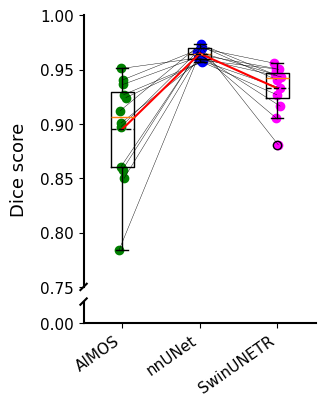

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from brokenaxes import brokenaxes
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.linewidth'] = 1.5

plt.figure(figsize=(3,4))
ax = brokenaxes(ylims=((0,.02), (0.75, 1)), hspace=0.1)
ax.boxplot(
    [df["AIMOS"].values, df["nnUNet"].values, df["SwinUNETR"].values],
    meanline=True, showmeans=True,
    meanprops={'color': 'k'}
);

labels = df.columns[1:].tolist()
palette = ["g", "b", "magenta"]

ax.set_xticks(range(1,4), labels, rotation=35,
              ha="right")

xs = [np.random.normal(1, 0.02, len(df)), np.random.normal(2, 0.02, len(df)), np.random.normal(3, 0.02, len(df))]

for i, exp in enumerate(labels):
    ax.scatter(xs[i], df[exp].values, color=palette[i])
    
for i in range(len(df)):
    ax.plot(
        (xs[0][i], xs[1][i]),
        (df["AIMOS"].values[i], df["nnUNet"].values[i]),
        linewidth=0.3,
        color="k"
    )
    
for i in range(len(df)):
    ax.plot(
        (xs[1][i], xs[2][i]),
        (df["nnUNet"].values[i], df["SwinUNETR"].values[i]),
        linewidth=0.3,
        color="k"
    )
    
ax.plot(
    (1, 2),
    (df[labels[0]].mean(), df[labels[1]].mean()),
    color="r"
)

ax.plot(
    (2, 3),
    (df[labels[1]].mean(), df[labels[2]].mean()),
    color="r"
)

ax.set_ylabel("Dice score", fontsize=13, labelpad=40)
plt.savefig(f"{EVALDIR}/../FIGURES/revision1/segmentation_compare.svg", bbox_inches="tight", dpi=1000)

In [60]:
import SimpleITK as sitk
from mousechd.datasets.utils import anyview2LPS

imagine = sitk.ReadImage(f"{DATADIR}/processed/Imagine/images/N_220H_0000.nii.gz")
imagine = sitk.GetArrayFromImage(imagine)
aimos = sitk.ReadImage(f"{OUTDIR}/AIMOS/data/NACT/M03_004h/C00.nii.gz")
aimos = anyview2LPS(aimos)
aimos = sitk.GetArrayFromImage(aimos)
malimban = sitk.ReadImage(f"{OUTDIR}/Malimban_et_al_2020/data/1_nativeCTdata/M01_002h/CT280.hdr")
malimban = anyview2LPS(malimban)
malimban = sitk.GetArrayFromImage(malimban)

NiftiImageIO (0x6ef4bb0): /home/hnguyent/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/Malimban_et_al_2020/data/1_nativeCTdata/M01_002h/CT280.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x6ef4bb0): /home/hnguyent/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/Malimban_et_al_2020/data/1_nativeCTdata/M01_002h/CT280.hdr is Analyze file and it's deprecated 



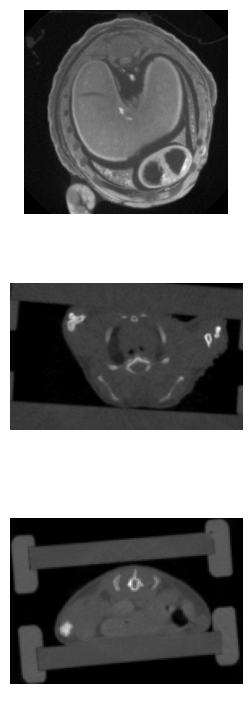

In [80]:
plt.subplots(figsize=(3, 9))
plt.axis("off")
plt.subplot(3, 1,1)
plt.imshow(imagine[imagine.shape[0]//2], cmap="gray")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(aimos[:, 70, :], cmap="gray")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(aimos[:, 70, :], cmap="gray")
plt.axis("off")
plt.subplot(3, 1, 3)
plt.imshow(malimban[50], cmap="gray")
plt.axis("off")
plt.savefig(f"{EVALDIR}/../FIGURES/revision1/Imagine_AIMOS_Malimban.svg", bbox_inches="tight", dpi=1000)

### Classification

In [116]:
from mousechd.classifier.utils import calculate_metrics

df = pd.DataFrame({"metric": ["balanced accuracy", "sensitivity", "specificity", "AUC"]})
for f in range(1, 6):
    f_df = pd.read_csv(f"{OUTDIR}/Classifier/F{f}/results/best_model.hdf5/test.csv")
    res = calculate_metrics(f_df["prob"].values, f_df["label"].values)
    df[f"F{f}"] = [res["bal_acc"], res["sens"], res["spec"], res["auc"]]
    
mousechd_df = df.set_index("metric", drop=True)

df = pd.DataFrame({"metric": ["balanced accuracy", "sensitivity", "specificity", "AUC"]})
for f in range(1, 6):
    f_df = pd.read_csv(f"{OUTDIR}/MONAI/classification/F{f}.csv")
    res = calculate_metrics(f_df["prob"].values, f_df["label"].values)
    df[f"F{f}"] = [res["bal_acc"], res["sens"], res["spec"], res["auc"]]
    
monai_df = df.set_index("metric", drop=True)

In [122]:
monai_df

,F1,F2,F3,F4,F5
metric,,,,,
balanced accuracy,0.9375,0.904762,0.9375,0.9375,0.928571
sensitivity,0.8750,1.000000,0.8750,0.8750,0.857143
specificity,1.0000,0.809524,1.0000,1.0000,1.000000
AUC,1.0000,0.965986,1.0000,1.0000,1.000000


In [123]:
mousechd_df

,F1,F2,F3,F4,F5
metric,,,,,
balanced accuracy,0.9125,0.976190,0.9375,0.88750,1.0
sensitivity,0.8750,1.000000,0.8750,0.87500,1.0
specificity,0.9500,0.952381,1.0000,0.90000,1.0
AUC,0.9500,1.000000,0.9500,0.89375,1.0


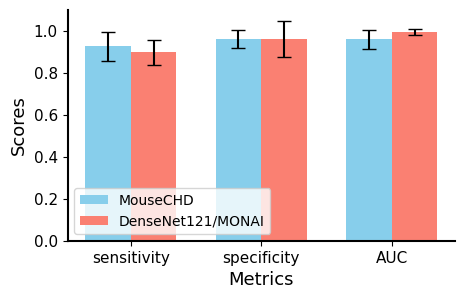

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = mousechd_df.copy()
df2 = monai_df.copy()

# Select only the metrics to plot (sensitivity, specificity, and AUC)
metrics = ['sensitivity', 'specificity', 'AUC']
df1_selected = df1.loc[metrics]
df2_selected = df2.loc[metrics]

# Calculate mean and standard deviation for each metric
means1 = df1_selected.mean(axis=1)
stds1 = df1_selected.std(axis=1)
means2 = df2_selected.mean(axis=1)
stds2 = df2_selected.std(axis=1)

# Plot
x = np.arange(len(metrics))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(5, 3))
bars1 = ax.bar(x - width/2, means1, width, yerr=stds1, label='MouseCHD', capsize=5, color='skyblue')
bars2 = ax.bar(x + width/2, means2, width, yerr=stds2, label='DenseNet121/MONAI', capsize=5, color='salmon')

# Labels and title
ax.set_xlabel('Metrics', fontsize=13)
ax.set_ylabel('Scores', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig(f"{EVALDIR}/../FIGURES/revision1/classification_comparision.svg", bbox_inches="tight", dpi=1000)


## Receptive field

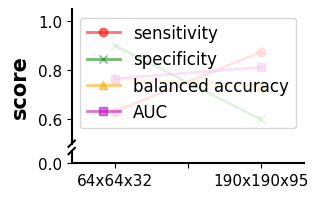

In [154]:
import json

results = json.load(open(f"{EVALDIR}/model_results.json", "r"))

metrics_name = ["sensitivity",
                "specificity",
                "balanced accuracy",
                "AUC"]

df = pd.DataFrame(columns=metrics_name)

for k, v in results.items():
    if k == "whole scans":
        df.loc["64x64x32", :] = v
    if k == "whole scans big":
        df.loc["190x190x95"] = v

markers = ("o", "x", "^", 's')
colors = ("r", "g", 'orange', 'm')

plt.figure(figsize=(3, 2))
ax = brokenaxes(ylims=((0,.05), (0.5, 1.05)), hspace=0.1)

for i, metric in enumerate(metrics_name):
    ax.plot(
        [1,2],
        df[metric],"{}-".format(markers[i]), 
        label=metric, 
        linewidth=2, 
        alpha=0.55,
        color=colors[i],
    )
    
ax.set_xticks([1,2], df.index);
ax.set_xlim([0.7,2.3])

ax.set_ylabel("score", fontsize=15, weight='bold')
ax.legend(fontsize=12)
plt.savefig(f"{EVALDIR}/../FIGURES/revision1/RF_compare.svg", bbox_inches="tight", dpi=1000)

In [ ]:
import tifffile

imname = "NH_341m"
pos_im = tifffile.imread(f"{OUTDIR}/GradCAMs/WholeScanNew/positives/{imname}/image.tif")
pos_cam = tifffile.imread(f"{OUTDIR}/GradCAMs/WholeScanNew/positives/{imname}/cam.tif")

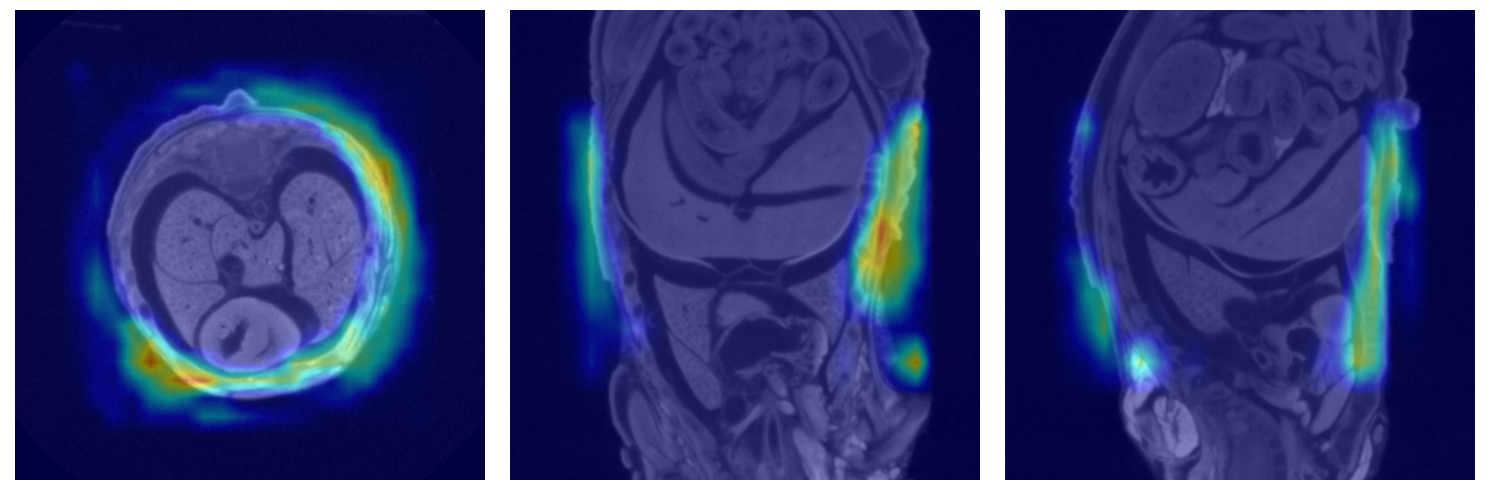

In [182]:
plt.subplots(figsize=(15, 5))
plt.axis("off")
plt.subplot(1,3,1)
i = 320
plt.imshow(pos_im[i], cmap="gray")
plt.imshow(pos_cam[i], alpha=0.5)
plt.axis("off")

plt.subplot(1,3,2)
i = 320
plt.imshow(pos_im[:, i, :], cmap="gray")
plt.imshow(pos_cam[:, i, :], alpha=0.5)
plt.axis("off")

plt.subplot(1,3,3)
i = 300
plt.imshow(pos_im[:, :, i], cmap="gray")
plt.imshow(pos_cam[:, :, i], alpha=0.5)
plt.axis("off")

plt.tight_layout()

plt.savefig(f"{EVALDIR}/../FIGURES/revision1/RF_GradCAMs.svg", bbox_inches="tight", dpi=1000)